In [6]:
import os
import shutil
import math
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder 
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary
import time
import copy
from PIL import Image

In [7]:

 
original_dataset_dir = './img'   
classes_list = os.listdir(original_dataset_dir) 

train_dir = './img/'

FileNotFoundError: [WinError 3] 지정된 경로를 찾을 수 없습니다: './img'

In [67]:

 
for cls in classes_list:
    path = os.path.join(original_dataset_dir, cls)
    fnames = os.listdir(path)
 
    train_size = math.floor(len(fnames))

    
    train_fnames = fnames[:train_size]
    print("Train size(",cls,"): ", len(train_fnames))
    for fname in train_fnames:
        src = os.path.join(path, fname)
        dst = os.path.join(os.path.join(train_dir, cls), fname)

        


Train size( birthday ):  50
Train size( cool ):  50
Train size( study ):  50
Train size( warm ):  50


In [4]:

USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
BATCH_SIZE = 256 
EPOCH = 30 

In [5]:

 
transform_base = transforms.Compose([transforms.Resize((64,64)), transforms.ToTensor()]) 
train_dataset = ImageFolder(root=train_dir, transform=transform_base) 

NameError: name 'train_dir' is not defined

In [77]:


train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)

In [10]:
class Net(nn.Module): 
  
    def __init__(self): 
    
        super(Net, self).__init__() 

        self.conv1 = nn.Conv2d(3, 32, 3, padding=1) 
        self.pool = nn.MaxPool2d(2,2)  
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)  
        self.conv3 = nn.Conv2d(64, 64, 3, padding=1)  

        self.fc1 = nn.Linear(4096, 512) 
        self.fc2 = nn.Linear(512, 4) 
    
    def forward(self, x):  
    
        x = self.conv1(x)
        x = F.relu(x)  
        x = self.pool(x) 
        x = F.dropout(x, p=0.25, training=self.training) 

        x = self.conv2(x)
        x = F.relu(x) 
        x = self.pool(x) 
        x = F.dropout(x, p=0.25, training=self.training)

        x = self.conv3(x) 
        x = F.relu(x) 
        x = self.pool(x) 
        x = F.dropout(x, p=0.25, training=self.training)

        x = x.view(-1, 4096)  
        x = self.fc1(x) 
        x = F.relu(x) 
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.fc2(x) 

        return F.log_softmax(x, dim=1)  

model_base = Net().to(DEVICE)  
optimizer = optim.Adam(model_base.parameters(), lr=0.001) 

In [83]:


summary(model_base, (3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 64, 64]             896
         MaxPool2d-2           [-1, 32, 32, 32]               0
            Conv2d-3           [-1, 64, 32, 32]          18,496
         MaxPool2d-4           [-1, 64, 16, 16]               0
            Conv2d-5           [-1, 64, 16, 16]          36,928
         MaxPool2d-6             [-1, 64, 8, 8]               0
            Linear-7                  [-1, 512]       2,097,664
            Linear-8                    [-1, 4]           2,052
Total params: 2,156,036
Trainable params: 2,156,036
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.05
Forward/backward pass size (MB): 2.04
Params size (MB): 8.22
Estimated Total Size (MB): 10.31
----------------------------------------------------------------


In [94]:
def train(model, train_loader, optimizer):
    model.train()  
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(DEVICE), target.to(DEVICE) 
        
        optimizer.zero_grad() 
        output = model(data)  
        loss = F.cross_entropy(output, target) 
        loss.backward()  
        optimizer.step()  

In [97]:
def evaluate(model, test_loader):
    model.eval()  
    test_loss = 0 
    correct = 0   
    
    with torch.no_grad(): 
        for data, target in test_loader:  
            data, target = data.to(DEVICE), target.to(DEVICE)  
            output = model(data) 
            test_loss += F.cross_entropy(output,target, reduction='sum').item() 
 
            
            pred = output.max(1, keepdim=True)[1]
            
            correct += pred.eq(target.view_as(pred)).sum().item() 
   
    test_loss /= len(test_loader.dataset) 
    test_accuracy = 100. * correct / len(test_loader.dataset) 
    return test_loss, test_accuracy  

In [98]:

 
def train_baseline(model ,train_loader, optimizer, num_epochs = 30):
    best_acc = 0.0  
    best_model_wts = copy.deepcopy(model.state_dict()) 
 
    for epoch in range(1, num_epochs + 1):
        since = time.time()  
        train(model, train_loader, optimizer)
        train_loss, train_acc = evaluate(model, train_loader) 
        
        if best_acc < train_acc:
            best_acc = train_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save(best_model_wts,f'baseline_{epoch}.pt')
            
        time_elapsed = time.time() - since 
        print('-------------- epoch {} ----------------'.format(epoch))
        print('train Loss: {:.4f}, Accuracy: {:.2f}%'.format(train_loss, train_acc))   
        print('Completed in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60)) 
    model.load_state_dict(best_model_wts)  
    return model
 

base = train_baseline(model_base, train_loader, optimizer, EPOCH)  	 #(16)


torch.Size([200, 3, 64, 64])
torch.Size([200, 4])
-------------- epoch 1 ----------------
train Loss: 0.4487, Accuracy: 87.50%
Completed in 0m 15s
torch.Size([200, 3, 64, 64])
torch.Size([200, 4])
-------------- epoch 2 ----------------
train Loss: 0.4232, Accuracy: 90.50%
Completed in 0m 15s
torch.Size([200, 3, 64, 64])
torch.Size([200, 4])
-------------- epoch 3 ----------------
train Loss: 0.4325, Accuracy: 89.00%
Completed in 0m 15s
torch.Size([200, 3, 64, 64])
torch.Size([200, 4])
-------------- epoch 4 ----------------
train Loss: 0.4298, Accuracy: 88.00%
Completed in 0m 15s
torch.Size([200, 3, 64, 64])
torch.Size([200, 4])
-------------- epoch 5 ----------------
train Loss: 0.4003, Accuracy: 89.00%
Completed in 0m 15s
torch.Size([200, 3, 64, 64])
torch.Size([200, 4])
-------------- epoch 6 ----------------
train Loss: 0.3765, Accuracy: 91.50%
Completed in 0m 15s
torch.Size([200, 3, 64, 64])
torch.Size([200, 4])
-------------- epoch 7 ----------------
train Loss: 0.3878, Accuracy

In [15]:

image_name = 'IMG_3344.JPG'
transform_base = transforms.Compose([transforms.Resize([64,64]),transforms.ToTensor()])
image_path = f"./test/{image_name}"
test_base = (transform_base(Image.open(image_path))).to(DEVICE)
test_loader_base = torch.utils.data.DataLoader(test_base, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

cool


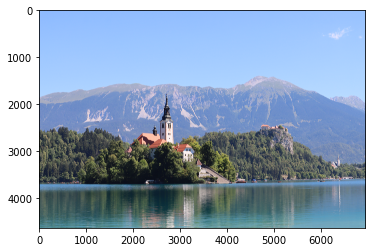

In [16]:
import matplotlib.pyplot as plt

classes = ['birthday','cool','study','warm']

base = Net().to(DEVICE)  
baseline=torch.load('./dict/baseline_24.pt') 
base.load_state_dict(baseline)
base.eval()  
result = base(test_base.unsqueeze(0)).to(DEVICE)

image = plt.imread(f"./test/{image_name}")
plt.imshow(image)
print(classes[torch.argmax(result)])
# print('baseline test acc:  ', test_accuracy)